In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd

In [7]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [10]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [11]:
# reflect an existing database into a new model
# reflect the tables
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [15]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [16]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)
print("--------------------------")
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)


('2017-08-23',)
--------------------------
2016-08-23


In [22]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()


In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df

# Sort the dataframe by date
prcp_data_df.set_index('date')
df=prcp_data_df.replace(np.nan,0)
df

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


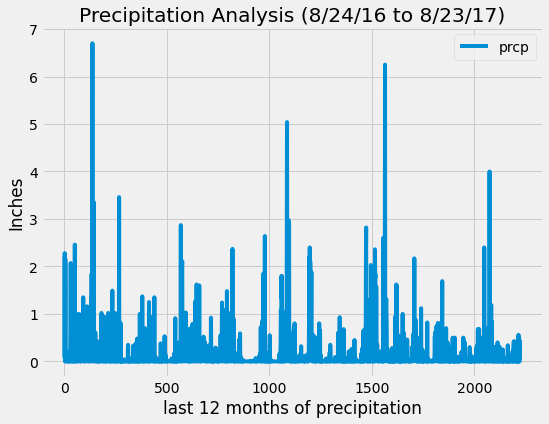

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(figsize=(8,6))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_xlabel('last 12 months of precipitation')
ax.set_ylabel('Inches')
plt.show()

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(locations))

There are 9 stations available.


In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by(Measurement.station.desc()).all()
active_stations

[('USC00519523', 2669),
 ('USC00519397', 2724),
 ('USC00519281', 2772),
 ('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00513117', 2709),
 ('USC00511918', 1979)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temperature = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by(Measurement.station.desc()).limit(1)[0][0]
lowest_temperature

'USC00519523'

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==lowest_temperature).all()


[(56.0, 85.0, 74.5436493068565)]

In [30]:
temp_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==lowest_temperature).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

,tobs
0,82.0
1,82.0
2,82.0
3,85.0
4,83.0


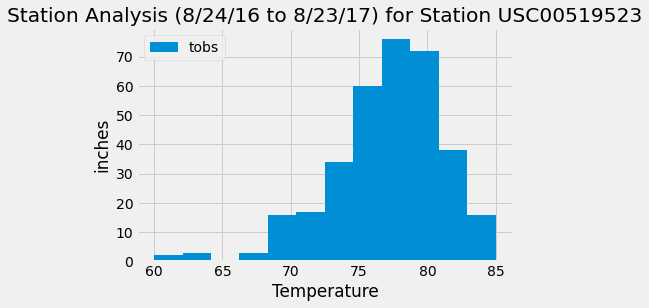

In [31]:
plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("inches")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + lowest_temperature)
plt.legend(["tobs"])
plt.show()

## Bonus Challenge Assignment

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017,2,20)
end_date = dt.date(2017,3,5)
print(calc_temps(start_date,end_date))
result_temp = calc_temps(start_date,end_date)

tmin = [r[0] for r in result_temp]
tavg = [r[1] for r in result_temp]
tmax = [r[2] for r in result_temp]

print(f"In order tmin,tavg,tmax: {tmin},{tavg},{tmax}")

[(61.0, 70.5813953488372, 78.0)]
In order tmin,tavg,tmax: [61.0],[70.5813953488372],[78.0]


[70.5813953488372]
17.0


<ErrorbarContainer object of 3 artists>

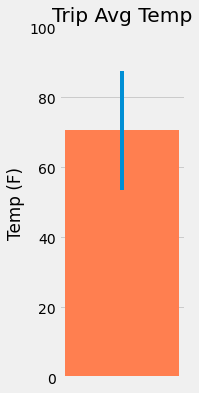

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
print(tavg)
x_axis = end_date

plt.rcParams['figure.figsize'] = [2, 6]
fig, ax = plt.subplots()
ax.bar(x_axis, tavg, color = "coral", align="center", width = 0.8)
ax.set_title("Trip Avg Temp")
ax.set_xlabel("Trip Average")
ax.set_ylabel("Temp (F)")
ax.set_ylim(0,100)
error = tmax[0] - tmin[0]
print(error)
ax.xaxis.set_visible(False)
ax.errorbar(x=x_axis, y=tavg, yerr=error)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
